In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Regresión lineal múltiple
**Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

Previamente, estudiamos un caso de regresión lineal simple. Ahora, podemos aplicar los mismos conceptos en un caso de regresión lineal múltiple. Para ello, resolveremos un problema de predicción de las ganancias de una empresa emergente, basándonos en sus gastos en marketing, I+D y administración, además de su ubicación. Tenemos los datos de 50 empresas emergentes ubicadas en Nueva York, California y Florida. La fuente de nuestros datos proviene de [Kaggle](https://www.kaggle.com/datasets/farhanmd29/50-startups)

In [2]:
dataset = pd.read_csv("datasets/50_Startups.csv") 
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


Veamos una descripción del conjunto de datos:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


Todas las observaciones están completas. Los atributos que tenemos son:

- **R&D Spend**: Monto que una startup gasta en I+D.
- **Administration**: Monto que una startup gasta en administración.
- **Marketing Spend**: Monto que una startup gasta en marketing.
- **State**: Estado en el que se encuentra ubicada. Es una *variable categorica*
- **Profit**: Ganancias de la empresa. Es nuestro **label**

Veamos una descripción estadística de las variables numéricas:

In [4]:
dataset.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


A simple vista, se observa una distribución lógica de los valores, sin datos faltantes o fuera de rango (por ejemplo, valores negativos). Que la media y la mediana estén cerca nos da una idea de que tenemos una distribución simétrica. Ahora, veamos en más detalle las distribuciones:

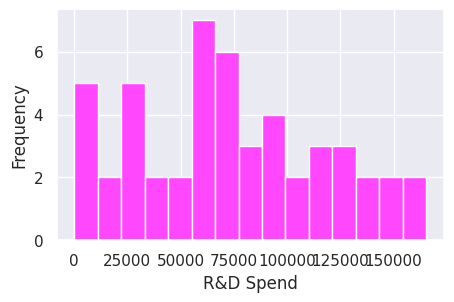

In [5]:
plt.figure(figsize=(5, 3))
dataset["R&D Spend"].hist(bins=15, color='#ff48fd')
plt.xlabel("R&D Spend")
plt.ylabel("Frequency")
plt.show()

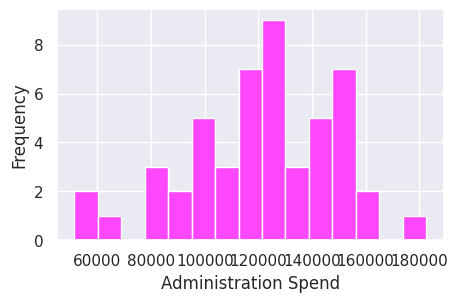

In [6]:
plt.figure(figsize=(5, 3))
dataset["Administration"].hist(bins=15, color='#ff48fd')
plt.xlabel("Administration Spend")
plt.ylabel("Frequency")
plt.show()

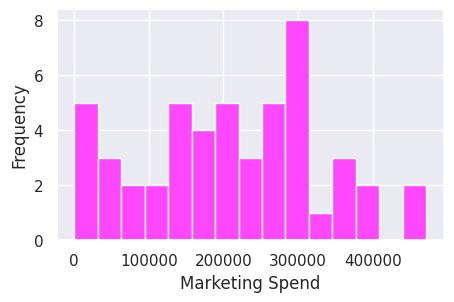

In [7]:
plt.figure(figsize=(5, 3))
dataset["Marketing Spend"].hist(bins=15, color='#ff48fd')
plt.xlabel("Marketing Spend")
plt.ylabel("Frequency")
plt.show()

Veamos la distribución del target `Profit`:

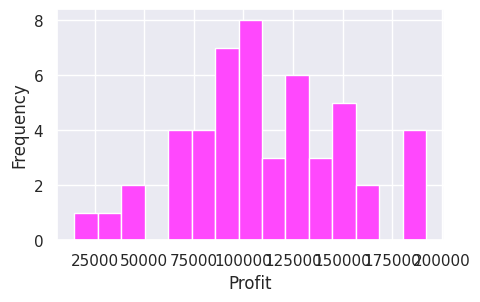

In [8]:
plt.figure(figsize=(5, 3))
dataset["Profit"].hist(bins=15, color='#ff48fd')
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.show()

A priori, no vemos ninguna distribución clara, tanto en los atributos como en el label.

Ahora, veamos la variable categórica `State` y analicémosla:

In [9]:
print(f"Tenemos {dataset.State.nunique()} categorías en 'State'. Estas son:")
dataset["State"].unique()

Tenemos 3 categorías en 'State'. Estas son:


array(['New York', 'California', 'Florida'], dtype=object)

Veamos cómo se distribuyen las observaciones entre las tres ciudades:

In [10]:
dataset["State"].value_counts()

State
New York      17
California    17
Florida       16
Name: count, dtype: int64

Esto nos indica que tenemos una distribución homogénea de startups por ciudad.

Sin embargo, esta variable tal como está no la podemos utilizar directamente. Por lo tanto, necesitamos codificarla para poder incluirla en la regresión lineal. La forma en que vimos en clase es usar **one-hot encoding**. Para ello, vamos a usar el procesador de **scikit-learn** llamado `OneHotEncoder`, sobre el cual puedes ver más información [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [11]:
from sklearn.preprocessing import OneHotEncoder

Como vimos en los videos, para evitar la trampa de las variables dummy, debemos descartar una de las columnas. Para ello, debemos indicarlo como argumento, lo que hará que se elimine la primera categoría:

In [12]:
encoder = OneHotEncoder(drop='first')

Veamos cómo se usa. Primero, debemos configurar el codificador utilizando el método .fit()`:

In [13]:
encoder.fit(dataset[["State"]])

OneHotEncoder(drop='first')

Una vez que nuestro procesador está configurado, podemos utilizarlo con el método `.transform()`:

In [16]:
encoded_state = encoder.transform(dataset[["State"]]).toarray()
encoded_state[:5, :]

array([[0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

Observamos que el codificador generó dos columnas, ya que tenemos tres clases y descartamos una. Las categorías seleccionadas son:

In [17]:
encoded_columns = encoder.get_feature_names_out()
encoded_columns

array(['State_Florida', 'State_New York'], dtype=object)

Como podemos ver, nos quedamos con las categorías `Florida` y `New York`. Entonces, si tenemos el caso `[0, 0]`, significa que la startup está en `California`.

Para continuar con nuestro análisis estadístico, añadimos la salida del codificador en nuestro dataframe:

In [19]:
encoded_df = pd.DataFrame(encoded_state, columns=encoded_columns)

# Unimos las columnas codificadas con el DataFrame original
dataset_with_dummies = pd.concat([dataset, encoded_df], axis=1)

# Eliminamos la columna 'State'
dataset_with_dummies = dataset_with_dummies.drop(columns=["State"])

dataset_with_dummies.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0.0,1.0
1,162597.70,151377.59,443898.53,191792.06,0.0,0.0
2,153441.51,101145.55,407934.54,191050.39,1.0,0.0
3,144372.41,118671.85,383199.62,182901.99,0.0,1.0
4,142107.34,91391.77,366168.42,166187.94,1.0,0.0


Ahora, podemos ver el mapa de correlación cruzada:

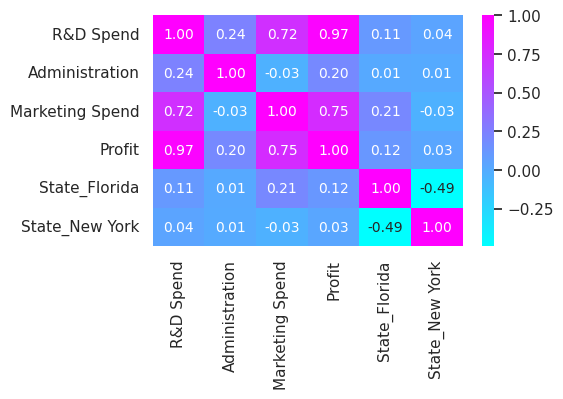

In [20]:
# Calculamos la correlación cruzada
correlacion_profit = dataset_with_dummies.corr()

plt.figure(figsize=(5, 3))
sns.heatmap(correlacion_profit, annot=True, cmap='cool', annot_kws={"size": 10}, fmt=".2f", cbar=True)
plt.show()

Vemos que `Profit` presenta una alta correlación con `R&D Spend`, y en segundo lugar con `Marketing Spend`. Los demás atributos parecen no tener una gran correlación.

Entre los atributos, parece haber una correlación entre `R&D Spend` y `Marketing Spend`. Todo indica que las empresas que gastan en I+D también tienden a gastar en Marketing. Los gastos de `Administration` parecen no estar correlacionados con nada. Y, por último, no parece haber correlación entre los atributos y la ubicación de las startups.

Una forma de visualizar las diferentes nubes de puntos y dejar más claro las correlaciones es mediante el `pairplot` de Seaborn. Aunque este gráfico puede volverse algo difícil de leer si hay muchos atributos:

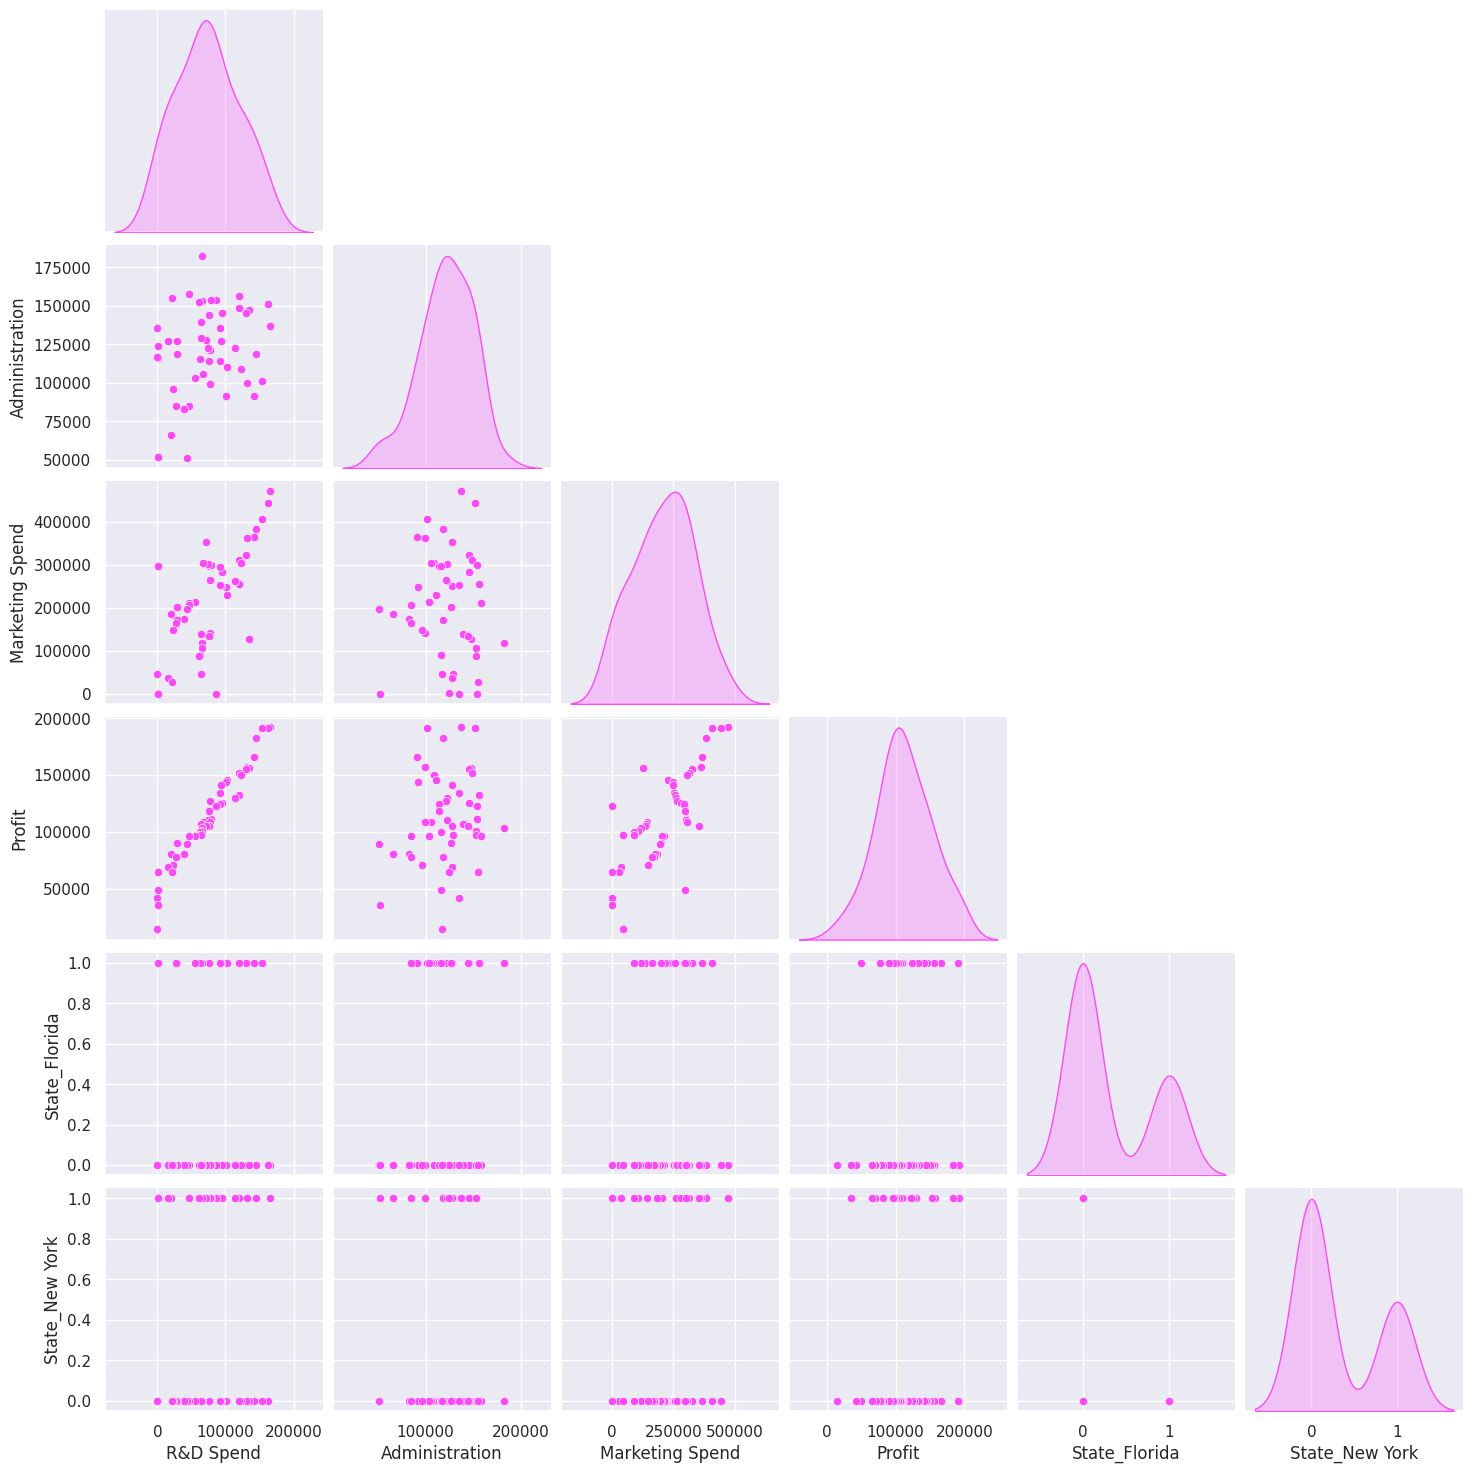

In [21]:
sns.pairplot(data=dataset_with_dummies, diag_kind="kde", corner=True, plot_kws={'color': '#ff48fd'}, diag_kws={'color': '#ff48fd'});

---
## Apliquemos la regresión

Una vez hecho el análisis, veamos cómo aplicar la regresión usando todos los atributos sin ninguna otra consideración. Comencemos separando el dataset.

In [22]:
X = dataset.drop(columns='Profit')
y = dataset["Profit"]

Separamos el dataset en el conjunto de entrenamiento y el de evaluación, quedándonos con el 30% para el dataset de evaluación:

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Datos de train y de test
print("Dimensión de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimensión de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimensión de X_train: (35, 4)
Valores de y_train: 35
Dimensión de X_test: (15, 4)
Valores de y_test: 15


Ahora, como las variables numéricas tienen diferentes escalas, vamos a aplicar un método de estandarización usando [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html):

In [25]:
from sklearn.preprocessing import StandardScaler

Este preprocesador se utiliza de la misma manera que el codificador One-Hot Encoding que vimos previamente. Veamos, por ejemplo, cómo se usa con el atributo `R&D Spend`:

In [26]:
r_d_spend = X_train[["R&D Spend"]]

sc_r_d_spend = StandardScaler()

# Con el método fit_transform podemos hacer un fit y transform en un solo paso
r_d_spend_scaled = sc_r_d_spend.fit_transform(r_d_spend)

print(f"La media del escalador es {np.round(sc_r_d_spend.mean_[0], 2)}")
print(f"El desvío estándar del escalador es {np.round(np.sqrt(sc_r_d_spend.var_[0]), 2)}")

La media del escalador es 73215.94
El desvío estándar del escalador es 46888.22


Veamos cómo quedan los valores escalados:

In [27]:
r_d_spend = pd.concat([r_d_spend.reset_index(drop=True), pd.DataFrame({"scaled": r_d_spend_scaled.squeeze()})], axis=1)
r_d_spend.head(10)

,R&D Spend,scaled
0,134615.46,1.309487
1,27892.92,-0.966618
2,1315.46,-1.533444
3,0.00,-1.561500
4,114523.61,0.880982
5,123334.88,1.068903
6,78013.11,0.102311
7,77044.01,0.081642
8,46426.07,-0.571356
9,61136.38,-0.257625


Con los preprocesadores definidos, ahora tenemos el modelo de regresión lineal, que es el que vimos previamente:

In [28]:
from sklearn.linear_model import LinearRegression

Entonces, tenemos todo el proceso listo. Queremos que el atributo categórico se procese con **one-hot encoding**, mientras que las variables numéricas se escalen. Una vez hecho esto, podemos aplicar la regresión lineal.

Todo esto lo podemos hacer en un solo paso usando la clase `Pipeline` de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), que incluirá todos los pasos dentro y se encargará de todo el proceso automáticamente. Para preprocesar las diferentes columnas de manera específica (categóricas y numéricas), utilizamos la clase [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), que nos permite aplicar transformaciones diferentes a cada tipo de columna. De esta manera, podemos procesar ambos tipos de datos de forma eficiente dentro del pipeline.

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definimos qué columnas son categóricas y cuáles numéricas
categorical_columns = ['State']
numerical_columns = ['R&D Spend', 'Administration', 'Marketing Spend']

# Creamos el preprocesamiento para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),  # Codificamos las categorías
        ('num', StandardScaler(), numerical_columns)    # Escalamos las variables numéricas
    ]
)

# Creamos el pipeline con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Aplicamos la regresión lineal
])

In [30]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['State']),
                                                 ('num', StandardScaler(),
                                                  ['R&D Spend',
                                                   'Administration',
                                                   'Marketing Spend'])])),
                ('regressor', LinearRegression())])

Con el pipeline creado, ya podemos entrenar la regresión lineal:

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['State']),
                                                 ('num', StandardScaler(),
                                                  ['R&D Spend',
                                                   'Administration',
                                                   'Marketing Spend'])])),
                ('regressor', LinearRegression())])

In [32]:
print(f"El valor de la intersección de la recta es {np.round(pipeline.named_steps['regressor'].intercept_, 2)}")
print(f"Los valores de los coeficientes de la recta son {np.round(pipeline.named_steps['regressor'].coef_, 2)}")

El valor de la intersección de la recta es 111466.35
Los valores de los coeficientes de la recta son [  458.07 -1235.16 37742.08 -2323.65  3236.03]


Los coeficientes de la regresión están dados por el orden introducido por el preprocesador:

In [33]:
pipeline.named_steps['preprocessor'].get_feature_names_out()

array(['cat__State_Florida', 'cat__State_New York', 'num__R&D Spend',
       'num__Administration', 'num__Marketing Spend'], dtype=object)

Dado que todos los atributos están escalados de la misma manera, podemos ver que el atributo `R&D Spend` es el más relevante, seguido por `Marketing Spend`. Aunque el valor absoluto de `Administration` es más bajo respecto a los otros, que su coeficiente sea negativo es interesante, ya que indica que, cuanto más gasta una empresa en administración, menos ganancia tendrá, a diferencia de los otros dos atributos, que tienen el efecto contrario.

In [34]:
print(f"El coeficiente de determinación (R^2) es {pipeline.score(X_train, y_train)}")

El coeficiente de determinación (R^2) es 0.9511471170962384


Finalmente, calculemos el desvío estándar del modelo:

In [35]:
y_model = pipeline.predict(X_train)
num_attributes = len(pipeline.named_steps['preprocessor'].get_feature_names_out())

std_dev_model = np.sqrt((np.sum((y_train - y_model)**2))/(y_train.size - num_attributes - 1))
print(f"Desvío estándar del modelo {round(std_dev_model, 3)}")

Desvío estándar del modelo 9921.136


## Evaluación

Veamos ahora cómo se comporta el rendimiento del modelo con respecto al conjunto de evaluación utilizando las siguientes métricas:

- $R^2$
- MAE
- MSE
- RMSE
- MAPE

Primero, importemos las métricas:


In [36]:
from sklearn.metrics import (r2_score, mean_absolute_error, 
                             mean_squared_error, root_mean_squared_error, 
                             mean_absolute_percentage_error)

Obtenemos las predicciones del modelo:

In [37]:
y_pred = pipeline.predict(X_test)

Ahora, calculemos las métricas:

In [38]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))
print("Raíz de error cuadrático medio:", round(rmse, 3))
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")

R-cuadrado en test: 0.94
Error absoluto medio: 7395.434
Error cuadrático medio: 84826955.035
Raíz de error cuadrático medio: 9210.155
Error absoluto porcentual medio: 8.93%


Vemos que el valor de $R^2$ sugiere que el ajuste es bastante bueno. Además, el valor de RMSE se encuentra en el mismo orden que el desvío estándar del modelo, lo que indica que no estamos enfrentando problemas de sobreajuste.

Sin embargo, surge la pregunta: aunque las métricas indican que el ajuste es bueno, ¿realmente es un buen modelo? Para evaluar esto, podemos comparar nuestro modelo con un **modelo base**. Esta práctica es muy importante en Machine Learning, ya que nos proporciona un punto de referencia para determinar si el modelo actual está realmente agregando valor en comparación con un enfoque más simple.

Para nuestro caso, utilizaremos como modelo base la media de las ganancias. Es decir, vamos a predecir que todas las startups tendrán una ganancia igual a la media del conjunto de entrenamiento:

In [39]:
mean_profit = np.mean(y_train)

y_pred_baseline = np.full_like(y_test, mean_profit)

Con este modelo base, calculemos las mismas métricas:

In [40]:
r2_baseline = r2_score(y_test, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = root_mean_squared_error(y_test, y_pred_baseline)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred_baseline)

print("R-cuadrado en test:", round(r2_baseline, 3))
print("Error absoluto medio:", round(mae_baseline, 3))
print("Error cuadrático medio:", round(mse_baseline, 3))
print("Raiz de error cuadrático medio:", round(rmse_baseline, 3))
print(f"Error absoluto porcentual medio: {mape_baseline*100:.2f}%")

R-cuadrado en test: -0.005
Error absoluto medio: 30301.288
Error cuadrático medio: 1413716446.334
Raiz de error cuadrático medio: 37599.421
Error absoluto porcentual medio: 35.79%


Al comparar nuestro modelo con el modelo base, podemos observar que el modelo entrenado es claramente superior. Por ejemplo, el MAE disminuye de $30301 a $7395, es decir, cuatro veces menor.

Ahora, la siguiente pregunta es: ¿realmente necesitábamos todos los atributos para obtener estos resultados? Este análisis lo realizaremos en otro notebook. Mientras tanto, guardemos el modelo:

In [41]:
import joblib

with open('reg_completo_50_startup.pkl', 'wb') as archivo:
    joblib.dump(pipeline, archivo)